# A5 1-D and 2-D Convolutional Neural Networks in Pytorch

* A5.4: *Changed structure of `CNN2D.__init__` by having it call `make_cnn_and_fc_layers` function. It is this function that `CNN1D` must override., not the `__init__` constructor.*
* A5.3: *Added two missing statements in `CNN2D` that initialize `layeri` to 0 and increment it by 1*
* A5.2: *added an exception to `CNN2D.__init__` code that provides a helpful message if you specify an impossible configuration for convolutional layers.  Repeat this exception code in your `CNN1D.__init__` function.*
* A5.1: *small edit in CNN2D to allow empty list for `n_hiddens_per_fc_layer`.*

In this assignment, you will experiment with the given convolutional neural network for 2-dimensional input samples (images), in class `CNN2D`, by applying it to the MNIST data.  You will also define a new class for handling 1-dimensional input samples, called `CNN1D`, that extends `CNN2D`.

In [2]:
import numpy as np
import torch
import pandas

import matplotlib.pyplot as plt

## `CNN2D` class

Here is a definition of `CNN2D`.

In [3]:
import numpy as np
import torch


class CNN2D(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)
        
        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
                # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds

        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

### CNN2D on MNIST Digits

We will use a bunch (50,000) images of hand drawn digits from [this deeplearning.net site](http://deeplearning.net/tutorial/gettingstarted.html).  Download `mnist.pkl.gz` if you don't already have it from A4. 

This pickle file includes data already partitioned into training, validation, and test sets.  To read it into python, use the following steps

In [4]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 784) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [5]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Would you like to run on the GPU? (y or n): y
Running on cuda:0


In [6]:
len(np.unique(Ttrain))

10

adam: Epoch 2 Loss 0.417
adam: Epoch 4 Loss 0.288
adam: Epoch 6 Loss 0.252
adam: Epoch 8 Loss 0.224
adam: Epoch 10 Loss 0.216
adam: Epoch 12 Loss 0.202
adam: Epoch 14 Loss 0.196
adam: Epoch 16 Loss 0.188
adam: Epoch 18 Loss 0.180
adam: Epoch 20 Loss 0.175


Text(0.5, 1.0, 'MNIST')

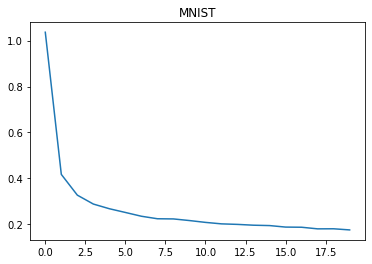

In [7]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST')

In [8]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    return conf_matrix

In [9]:
Classes, _ = cnnet.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 93.79


,0,1,2,3,4,5,6,7,8,9
0,96.224490,0.000000,0.816327,0.204082,0.408163,1.020408,0.306122,0.000000,0.612245,0.408163
1,0.000000,98.502203,0.264317,0.440529,0.000000,0.000000,0.088106,0.176211,0.440529,0.088106
2,0.678295,0.581395,94.961240,1.647287,0.290698,0.000000,0.290698,0.872093,0.581395,0.096899
3,0.198020,0.693069,2.772277,93.366337,0.000000,0.990099,0.000000,0.990099,0.792079,0.198020
4,0.203666,0.000000,0.407332,0.101833,93.991853,0.000000,1.120163,1.425662,0.407332,2.342159
5,0.448430,0.560538,0.112108,3.363229,0.000000,91.143498,1.233184,0.448430,2.242152,0.448430
6,0.521921,0.521921,0.000000,0.208768,1.252610,0.521921,94.885177,0.313152,1.670146,0.104384
7,0.194553,1.653696,2.431907,0.194553,0.291829,0.000000,0.000000,93.482490,0.097276,1.653696
8,0.616016,1.334702,3.593429,1.437372,0.308008,0.718686,0.924025,0.308008,89.835729,0.924025
9,0.891972,0.792864,0.099108,0.594648,3.072349,0.792864,0.297324,2.279485,0.594648,90.584737


### Experiments

To explore the effects of different CNN structures, show results for the following steps.  For each architecture, use the same number of epochs, batch size, and learning rate as used above.

1. Compare test accuracy of CNN2D nets with one, two and three convolutional layers, each with 10 units and patch sizes of 5 and strides of 1.
2. Using the best number of convolutional layers found in Step 1, compare the test accuracies of CNN2d nets with zero, one, and two fully-connected layers each with 10 hidden units.

Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

adam: Epoch 2 Loss 0.423
adam: Epoch 4 Loss 0.278
adam: Epoch 6 Loss 0.236
adam: Epoch 8 Loss 0.219
adam: Epoch 10 Loss 0.203
adam: Epoch 12 Loss 0.193
adam: Epoch 14 Loss 0.186
adam: Epoch 16 Loss 0.181
adam: Epoch 18 Loss 0.173
adam: Epoch 20 Loss 0.173
adam: Epoch 2 Loss 0.698
adam: Epoch 4 Loss 0.576
adam: Epoch 6 Loss 0.505
adam: Epoch 8 Loss 0.473
adam: Epoch 10 Loss 0.439
adam: Epoch 12 Loss 0.423
adam: Epoch 14 Loss 0.397
adam: Epoch 16 Loss 0.403
adam: Epoch 18 Loss 0.362
adam: Epoch 20 Loss 0.350
adam: Epoch 2 Loss 0.770
adam: Epoch 4 Loss 0.548
adam: Epoch 6 Loss 0.500
adam: Epoch 8 Loss 0.451
adam: Epoch 10 Loss 0.421
adam: Epoch 12 Loss 0.395
adam: Epoch 14 Loss 0.366
adam: Epoch 16 Loss 0.354
adam: Epoch 18 Loss 0.335
adam: Epoch 20 Loss 0.343
adam: Epoch 2 Loss 0.696
adam: Epoch 4 Loss 0.421
adam: Epoch 6 Loss 0.337
adam: Epoch 8 Loss 0.312
adam: Epoch 10 Loss 0.296
adam: Epoch 12 Loss 0.292
adam: Epoch 14 Loss 0.295
adam: Epoch 16 Loss 0.269
adam: Epoch 18 Loss 0.260
ad

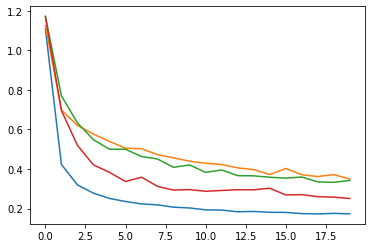

In [33]:
Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)


Xtrain1 = train_set[0]
Ttrain1 = train_set[1].reshape(-1, 1)

Xval1 = valid_set[0]
Tval1 = valid_set[1].reshape(-1, 1)

Xtest1 = test_set[0]
Ttest1 = test_set[1].reshape(-1, 1)

Xtrain1 = Xtrain1.reshape(-1, 1, 28, 28)
Xtest1 = Xtest1.reshape(-1, 1, 28, 28)


Xtrain2 = train_set[0]
Ttrain2 = train_set[1].reshape(-1, 1)

Xval2 = valid_set[0]
Tval2 = valid_set[1].reshape(-1, 1)

Xtest2 = test_set[0]
Ttest2 = test_set[1].reshape(-1, 1)

Xtrain2 = Xtrain2.reshape(-1, 1, 28, 28)
Xtest2 = Xtest2.reshape(-1, 1, 28, 28)


Xtrain3 = train_set[0]
Ttrain3 = train_set[1].reshape(-1, 1)

Xval3 = valid_set[0]
Tval3 = valid_set[1].reshape(-1, 1)

Xtest3 = test_set[0]
Ttest3 = test_set[1].reshape(-1, 1)

Xtrain3 = Xtrain3.reshape(-1, 1, 28, 28)
Xtest3 = Xtest3.reshape(-1, 1, 28, 28)
    
    
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)


n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')


n_hiddens_per_conv_layer1 = [10]
patch_size_per_conv_layer1 = [5]
stride_per_conv_layer1=[1]
n_hiddens_per_fc_layer1 = [5]

cnnet1 = CNN2D(28 * 28, n_hiddens_per_conv_layer1, n_hiddens_per_fc_layer1, len(np.unique(Ttrain1)), 
              patch_size_per_conv_layer1, stride_per_conv_layer1, device=device)

cnnet1.train(Xtrain1, Ttrain1, batch_size, n_epochs, learning_rate, method='adam')


n_hiddens_per_conv_layer2 = [10, 10]
patch_size_per_conv_layer2 = [5, 5]
stride_per_conv_layer2=[1, 1]
n_hiddens_per_fc_layer2 = [5]

cnnet2 = CNN2D(28 * 28, n_hiddens_per_conv_layer2, n_hiddens_per_fc_layer2, len(np.unique(Ttrain2)), 
              patch_size_per_conv_layer2, stride_per_conv_layer2, device=device)

cnnet2.train(Xtrain2, Ttrain2, batch_size, n_epochs, learning_rate, method='adam')

n_hiddens_per_conv_layer3 = [10, 10, 10]
patch_size_per_conv_layer3 = [5, 5, 5]
stride_per_conv_layer3=[1, 1, 1]
n_hiddens_per_fc_layer3 = [5]


cnnet3 = CNN2D(28 * 28, n_hiddens_per_conv_layer3, n_hiddens_per_fc_layer3, len(np.unique(Ttrain3)), 
              patch_size_per_conv_layer3, stride_per_conv_layer3, device=device)

cnnet3.train(Xtrain3, Ttrain3, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet.error_trace, label='Pytorch')

plt.plot(cnnet1.error_trace, label='Pytorch')
plt.plot(cnnet2.error_trace, label='Pytorch')
plt.plot(cnnet3.error_trace, label='Pytorch')


# Answer

### For this experiment, the hyperparameters were very similar. We can see that the addition of convolutional layers helped accuracy. The addition of layers helped improve the percent of correct outcomes by 1 to 3%. This means for this dataset the extra layers were beneficial to performance. My best performance was from the model with 3 convolutional layers. This was best because the CNN was able to see the patterns in the images over three layers, which meant distinguished features could be better identified. If this dataset were more complex than just pixels, we would need to find a new optimized model for more complex patterns. 

## CNN1D

Complete the following code cell to define `CNN1D`.  The only change from `CNN2D` that is required is in the constructor.  Complete these steps.

1. Copy the `make_conv_and_fc_layers` function from `CNN2D`.
2. For each convolutional layer, create a `torch.nn.Conv1d` object instead of a `torch.nn.Conv2d` object.
3. Modify the statement `input_hw = int(np.sqrt(n_inputs))` appropriately. `input_hw` refers to "input height width".  What would beed to change to make this make sense for a single dimensional sample?
4. Modify the statement `n_in = input_hw ** 2 * n_in` appropriately.

In [11]:
class CNN1D(CNN2D):
    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
             patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
             patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu')

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)

        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):

        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int((n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv1d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))


### Toy Data to Test `CNN1D`

Here is some toy data to test your `CNN1D` definition.  Each sample is now 1-dimensional.  Let's make vectors of two kinds, ones with square pulses and ones with triangular pulses, at random locations and random durations. Both kinds will be 100 values long, with zeros between the waves.

In [12]:
def make_square_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        sample[start:start + width] = 1
    return sample

In [13]:
square_pulse = make_square_pulse()
square_pulse

array([0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

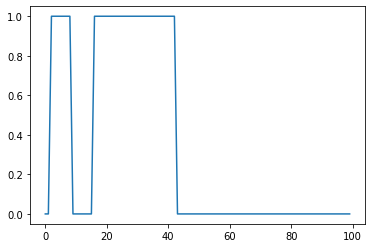

In [14]:
plt.plot(square_pulse)

In [15]:
def make_triangular_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        if width % 2 == 1:
            width += 1  # if odd, make it even
        sample[start:start + width // 2] = np.linspace(0, 1, width // 2)
        sample[start + width // 2:start + width] = np.linspace(1, 0, width // 2)
    return sample

In [16]:
triangular_pulse = make_triangular_pulse()
triangular_pulse

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.125     , 0.25      ,
       0.375     , 0.5       , 0.625     , 0.75      , 0.875     ,
       1.        , 1.        , 0.875     , 0.75      , 0.625     ,
       0.        , 0.14285714, 0.28571429, 0.42857143, 0.57142857,
       0.71428571, 0.85714286, 1.        , 1.        , 0.85714286,
       0.71428571, 0.57142857, 0.42857143, 0.28571429, 0.14285714,
       0.        , 0.6       , 0.8       , 1.        , 1.        ,
       0.        , 0.33333333, 0.66666667, 1.        , 1.        ,
       0.66666667, 0.33333333, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

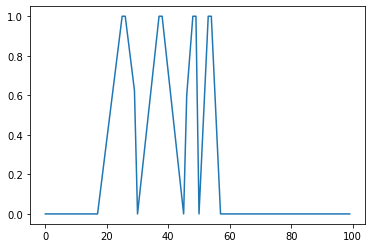

In [17]:
plt.plot(triangular_pulse)

In [18]:
n_each = 500
Xtrain = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttrain = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
n_each = 500
Xtest = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttest = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 100), (1000, 1), (1000, 100), (1000, 1))

In [19]:
np.newaxis == None

True

In [20]:
Xtrain = Xtrain[:, None, :]
Xtrain.shape

(1000, 1, 100)

In [21]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], 1, -1)
Xtest = Xtest.reshape(Xtest.shape[0], 1, -1)
Xtrain.shape, Xtest.shape

((1000, 1, 100), (1000, 1, 100))

adam: Epoch 10 Loss 0.590
adam: Epoch 20 Loss 0.341
adam: Epoch 30 Loss 0.118
adam: Epoch 40 Loss 0.037
adam: Epoch 50 Loss 0.031
adam: Epoch 60 Loss 0.002
adam: Epoch 70 Loss 0.001
adam: Epoch 80 Loss 0.000
adam: Epoch 90 Loss 0.000
adam: Epoch 100 Loss 0.000


Text(0.5, 1.0, 'Pulses')

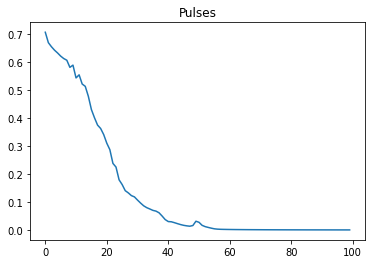

In [22]:
cnnet1 = CNN1D(100, [10, 5], [5, 5], 2, [10, 4], [1, 2], device=device)

n_epochs = 100
batch_size = 10
learning_rate = 0.001

cnnet1.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet1.error_trace, label='Pytorch')
plt.title('Pulses')

In [23]:
Classes, _ = cnnet1.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 99.70


,square,triangular
square,99.4,0.6
triangular,0.0,100.0


torch.Size([10, 10])

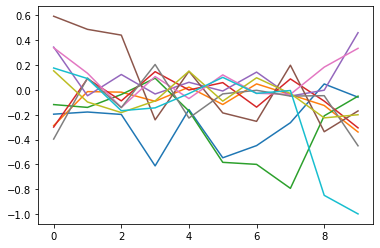

In [24]:
W = list(cnnet1.children())[0][0].weight.data.cpu()  # in case running on GPU
plt.plot(W[:, 0, :].T);
W[:, 0, :].T.shape

### Experiments on ECG Data

An [electrocardiogram](), or ECG, is a record in time of a voltage generated by the heart.  It can be used to diagnose abnormalities in the heart.

Public datasets containing ECG traces are available, such as the [Non-Invasive Fetal ECG Arrhythmia Database](https://physionet.org/content/nifeadb/1.0.0/) site. The data files there are in a standard waveform-database (WFDB) format.  As is often the case for most standard data formats you run in to, a python package exists for reading this data, called [wfdb](https://github.com/MIT-LCP/wfdb-python) that you can install using [conda](https://anaconda.org/conda-forge/wfdb).

This data set includes ECG from normal patients and from ones with arrythmias, with data file names like `ARR_01.dat` and `NR_01.dat`, respectively.  We have already downloaded these files, read them in using the `wfdb` package and collected them into segments of 2000 voltages.  The sample rate for this data is 1000 Hz, so 2000 voltages spans 2 seconds. Download this data set from [ecg.npy](https://www.cs.colostate.edu/~cs445/notebooks/ecg.npy) 

Now, our job for our `CNN1D` is to classify each 2000 sample segment into the classes `normal` or `arrythmia`.

After you have downloaded `ecg.npy`, you can load it and plot a few samples.

In [27]:
ecg = np.load('ecg.npy')
arr = ecg['arrythmia']
norm = ecg['normal']
arr.shape, norm.shape

((2429, 2000), (3634, 2000))

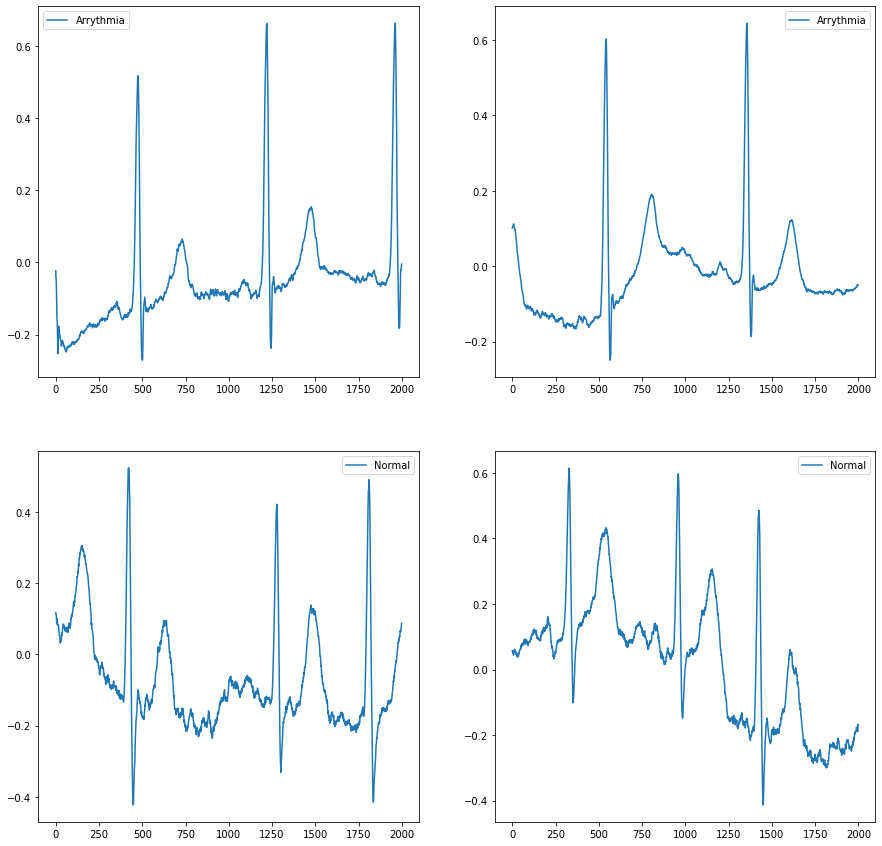

In [28]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(arr[0])
plt.legend(('Arrythmia',))
plt.subplot(2, 2, 2)
plt.plot(arr[100])
plt.legend(('Arrythmia',))

plt.subplot(2, 2, 3)
plt.plot(norm[0])
plt.legend(('Normal',))
plt.subplot(2, 2, 4)
plt.plot(norm[100])
plt.legend(('Normal',));

Now, let's stack the `arr` and `norm` samples together, create class labels for each sample, randomly rearrange them, and divide into train and test sets.

In [29]:
X = np.vstack((arr, norm))
X = X.reshape(X.shape[0], 1, -1)
T = np.hstack((['arr'] * arr.shape[0], ['nr'] * norm.shape[0])).reshape(-1, 1)
n_samples = X.shape[0]
rows = np.arange(n_samples)
np.random.shuffle(rows)
n_train = int(n_samples * 0.8)
Xtrain = X[rows[:n_train], ...]
Ttrain = T[rows[:n_train], ...]
Xtest = X[rows[n_train:], ...]
Ttest = T[rows[n_train:], ...]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((4850, 1, 2000), (4850, 1), (1213, 1, 2000), (1213, 1))

In [30]:
Ttrain

array([['arr'],
       ['nr'],
       ['arr'],
       ...,
       ['arr'],
       ['arr'],
       ['nr']], dtype='<U3')

Okay, ready to train.  Create a `CNN1D` network with a statements like this.

In [31]:
cnn1d = CNN1D(Xtrain.shape[-1], [5, 10], [10, 10], 2, [100, 20], [20, 5], device=device)

Now, experiment with at least ten different network structures, patch sizes and strides and compare them with the percent accuracy on test data.  Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

## Grading and Check-In
Download [A5grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A5grader.zip) and extract A5grader.py from it. Run the code in the following cell to demonstrate an example grading session. Remember to test your code with additional tests of your own design. Your notebook must be named as Lastname-A5.ipynb.  

When ready, submit your notebook via the A5 link in our class Canvas web page.

In [32]:
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Avery-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing

    xs = np.arange(100)
    n_each = 500
    n_samples = n_each * 2
    X = np.array([np.sin(xs / 2) + np.random.normal(0, 1, size=100) for i in range(n_each)] +
                 [np.sin(xs / 3) + np.random.normal(0, 1, size=100) for i in range(n_each)])
    X = X[:, np.newaxis, :]
    T = np.array([2] * n_each + [3] * n_each).reshape(-1, 1)
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    X = X[rows, ...]
    T = T[rows, ...]
    n_train = int(n_samples * 0.8)
    Xtrain = X[:n_train, ...]
    Ttrain = T[:n_train, :]
    Xtest = X[n_train:, ...]
    Ttest = T[n_train:, :]

    cnn1d = CNN1D(100, [5, 5], [3], 2, [10, 5], [1, 2])
    cnn1d.train(Xtrain, Ttrain, 10, 20, 0.01, method='adam')

    perc_train = 100 * np.mean(cnn1d.u

## Extra Credit
Earn up to 3 extra credit points on this assignment by doing any or all of the following experiments. 

1. Compare your results on the MNIST data by using `relu` versus `tanh` activation functions. Show and discuss the results.
2. Compare your results on the MNIST data using `adam` versus `sgd`. Show and discuss the results.
3. Download another image data set, apply your `CNN2D` class to this data and discuss the results.